In [1]:
import pickle
import os
import json

from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
import numpy as np
import pandas as pd
import torch, torchvision.transforms as T
import open_clip                                            

from sparc.post_analysis import HDF5AnalysisResultsDataset
from sparc.feature_extract.extract_open_images import OpenImagesDataset
from sparc.model.model_global import MultiStreamSparseAutoencoder
from sparc.heatmaps.clip import create_wrapped_clip
from sparc.heatmaps.dino import create_wrapped_dinov2
from sparc.heatmaps.visualization import (show_clean_text_attribution, 
                                          plot_all_attributions, 
                                          show_clean_gradcam_text,  
                                          plot_relevancy_attributions)
from sparc.heatmaps.attention_relevance import interpret_sparc, interpret_clip
from sparc.heatmaps.gradcam import compute_gradcam

In [2]:
checkpoint_dir = "../../final_results/msae_open_global_with_cross"
dataset = OpenImagesDataset('/home/ubuntu/Projects/OpenImages/', 'test')

Loading caption data from /home/ubuntu/Projects/OpenImages/captions/test/simplified_open_images_test_localized_narratives.json...
Loading label data...
Total number of classes: 601
Loading annotations from /home/ubuntu/Projects/OpenImages/labels/test-annotations-human-imagelabels-boxable.csv...
Loaded labels for 112194 images


In [3]:
def get_concept_name_by_latent(analysis_results, purity_threshold = 0.3):
    print("Loading Annotations")
    annotations_file = os.path.join(dataset.labels_dir, 
                               f'{dataset.split}-annotations-human-imagelabels-boxable.csv')
    annotations_df = pd.read_csv(annotations_file)
    # Filter for positive labels (Confidence=1) if that column exists
    if 'Confidence' in annotations_df.columns:
        annotations_df = annotations_df[annotations_df['Confidence'] == 1]
    label_df = annotations_df.groupby('LabelName').count()
    class_to_count = {dataset.label_to_class[label]:count for label, count in list(zip(label_df.index, label_df['ImageID']))}

    print("Loading  the matrices")
    all_original_indices = analysis_results.get_all_original_dataset_indices()
    index_to_position_map = {original_idx: pos for pos, original_idx in enumerate(all_original_indices)}
    Y = label_matrix_sparse
    N = analysis_results.get_all_original_dataset_indices().shape[0]
    positions_for_labeled_samples = np.array([index_to_position_map[idx] for idx in sample_indices])
    
    print('computeing the dimensions')
    stream_dims = {}
    latent_activations = {} # Store filtered activations {stream: (N, L)}
    L = -1 # Latent dimension, should be consistent across streams
    streams = analysis_results.streams
    for s in tqdm(streams):
        if s not in analysis_results.streams:
             raise ValueError(f"Stream '{s}' not found in analysis_results.")

        stream_X_full = analysis_results.get_all_features_for_stream(s, 'latents', return_sparse=True)
        stream_X_filtered = stream_X_full[positions_for_labeled_samples]

        current_L = stream_X_filtered.shape[1]
        if L == -1:
            L = current_L # Set latent dimension from first stream
        elif current_L != L:
             raise ValueError(f"Inconsistent latent dimensions: Stream .")

        stream_dims[s] = L
        latent_activations[s] = stream_X_filtered


    concept_names_by_latent = [{s: '' for s in streams} for _ in range(L)]
    for l in tqdm(range(L)):
        all_stream_counts = []
        for s in streams:
            X = latent_activations[s]
            a = X[:, l].toarray().flatten()         
            active_mask = a>0
            active_top_idx = np.argsort(a[active_mask])[::-1][:50]
            n = active_top_idx.shape[0]
            if n == 0:
                concept_names_by_latent[l][s] = 'None'
                continue 

            counts = Y[active_mask][active_top_idx][:50].sum(axis=0)
            cat_idx = counts.argmax() # Index (0 to C-1) of the dominant class
            purity_score = counts[0, cat_idx] / n 

            # Assign concept name if purity meets threshold
            name = idx_to_class[cat_idx]
            if purity_score >= purity_threshold:# and class_recall>0.5 and class_total_count>10:

                # Get name using the provided label_names list or dict
                concept_names_by_latent[l][s] = name
            else:
                concept_names_by_latent[l][s] = 'None'  
    return concept_names_by_latent

Define the encoder models 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DINO_MODEL     = 'dinov2_vitl14_reg'          
CLIP_MODEL     = 'hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K'

DINO_TAG     = 'dinov2_vitl14_reg'          
CLIP_TAG     = 'CLIP-ViT-L-14-DataComp'
BATCH_SIZE     = 32

IMAGENET_MEAN, IMAGENET_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

class MaybeToTensor(T.ToTensor):
    def __call__(self, pic):
        return pic if isinstance(pic, torch.Tensor) else super().__call__(pic)

normalize = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
dino_transform = T.Compose([
    T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC), # original dino does it to 256 but it messes up the aspect ratio
#     T.CenterCrop(224),
    MaybeToTensor(),
    normalize,
])

model_clip, _, preprocess_clip = open_clip.create_model_and_transforms(CLIP_MODEL)

transform_list = preprocess_clip.transforms
preprocess_clip = T.Compose([T.Resize(size=(224, 224), interpolation=T.InterpolationMode.BICUBIC, antialias=True)] 
                            + transform_list[2:])

clip_tokenizer = open_clip.get_tokenizer(CLIP_MODEL)

model_clip = model_clip.to(device).eval()

model_dino = torch.hub.load('facebookresearch/dinov2', DINO_MODEL).to(device).eval()


# We need to capture gradients to calculate the attributions
model_clip = create_wrapped_clip(CLIP_MODEL, device)
model_clip = model_clip.enable_attention_capture()

model_dino = create_wrapped_dinov2(DINO_MODEL, device)
model_dino.enable_attention_capture()

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main


WrappedDINOv2(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_aff

Define the SPARC model

In [5]:
d_streams = {
    'dino'     : model_dino.num_features,             
    'clip_img' : model_clip.visual.output_dim,
    'clip_txt' : model_clip.visual.output_dim,
}

print('Loading MS-SAE checkpoint...')

with open(f'{checkpoint_dir}/run_config.json', 'r') as f:
    config = json.load(f)
model = MultiStreamSparseAutoencoder(
    d_streams=d_streams,
    n_latents=config['args']['n_latents'],       
    k=config['args']['k'],
).to(device)
model.load_state_dict(torch.load(f'{checkpoint_dir}/msae_checkpoint.pth', map_location=device, weights_only=False))
model.eval()

Loading MS-SAE checkpoint...


MultiStreamSparseAutoencoder(
  (encoders): ModuleDict(
    (dino): Linear(in_features=1024, out_features=8192, bias=False)
    (clip_img): Linear(in_features=768, out_features=8192, bias=False)
    (clip_txt): Linear(in_features=768, out_features=8192, bias=False)
  )
  (decoders): ModuleDict(
    (dino): Linear(in_features=8192, out_features=1024, bias=False)
    (clip_img): Linear(in_features=8192, out_features=768, bias=False)
    (clip_txt): Linear(in_features=8192, out_features=768, bias=False)
  )
  (pre_biases): ParameterDict(
      (dino): Parameter containing: [torch.cuda.FloatTensor of size 1024 (cuda:0)]
      (clip_img): Parameter containing: [torch.cuda.FloatTensor of size 768 (cuda:0)]
      (clip_txt): Parameter containing: [torch.cuda.FloatTensor of size 768 (cuda:0)]
  )
  (latent_biases): ParameterDict(
      (dino): Parameter containing: [torch.cuda.FloatTensor of size 8192 (cuda:0)]
      (clip_img): Parameter containing: [torch.cuda.FloatTensor of size 8192 (cuda:

In [6]:
idx_to_class = {value:key for key,value in dataset.class_to_idx.items()}
labels = []
sample_indices = []
for idx in range(len(dataset)):
    image_id, caption_idx = dataset.samples[idx]
    if image_id in dataset.image_to_label_tensor:
        labels_tensor = dataset.image_to_label_tensor[image_id]
        labels.append(csr_matrix(labels_tensor))
        sample_indices.append(idx)
sample_indices = np.array(sample_indices)
label_matrix_sparse = vstack(labels).tocsr()

In [7]:
if os.path.isfile(f'{checkpoint_dir}/concept_names_by_latent.pkl'):
    with open(f'{checkpoint_dir}/concept_names_by_latent.pkl', 'rb') as f:
        concept_names_by_latent = pickle.load(f)
else:
    analysis_results = HDF5AnalysisResultsDataset(f'{checkpoint_dir}/analysis_cache_val.h5',
                                                  batch_size_used_for_generation=256)
    concept_names_by_latent = get_concept_name_by_latent(analysis_results)

    with open(f'{checkpoint_dir}/concept_names_by_latent.pkl', 'wb') as f:
        pickle.dump(concept_names_by_latent, f)

In [8]:
concept = 'Cat'
k = []

for i in range(len(concept_names_by_latent)):
    all_consistent = True
    for stream in model.streams:
        if concept_names_by_latent[i][stream] != concept:
            all_consistent = False
    if all_consistent:
        k.append(i)

all_img_ids = [i[0] for i in dataset.samples]

img_ids = []
for img_id, labels in dataset.image_to_labels.items():
    if concept in labels:
        img_ids.append(img_id)
indices = [all_img_ids.index(i) for i in img_ids]

You can change the target k to different latents. You could also use all of the latents corresponding to that concept.

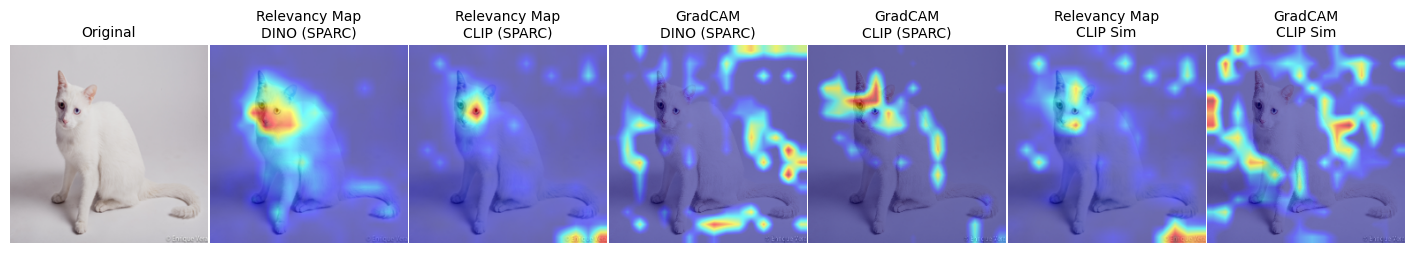

In [9]:
target_k = k[1]
# target_k = k
idx = indices[9]
        
# Clip needs shorter text to focus on the concept. You can also test the entire caption too
clip_sim_text = f"a {concept} " 

sparc_text = dataset[idx]['captions'] 

# Preprocess images for both models
img_clip = preprocess_clip(dataset[idx]['image']).unsqueeze(0).to(device)
img_dino = dino_transform(dataset[idx]['image']).unsqueeze(0).to(device)
tokenized_sparc_texts = clip_tokenizer(sparc_text).to(device)

start_layer_image = -1
start_layer_text = -1

# New function returns 3 values: clip_txt_relevance, clip_img_relevance, dino_relevance
clip_txt_relevance, clip_img_relevance, dino_relevance = interpret_sparc(
    tokenized_sparc_texts, model_clip, model_dino, img_clip, img_dino, model, device,
    target_k, start_layer=start_layer_image, start_layer_text=start_layer_text, 
    global_msae=True, use_cross_modal=False
)

tokenized_clip_texts = clip_tokenizer(clip_sim_text).to(device)
clip_txt_sim_relevance, clip_img_sim_relevance = interpret_clip(model=model_clip, image=img_clip, 
                                                                texts=tokenized_clip_texts, device=device, 
                                                                start_layer=start_layer_image, 
                                                                start_layer_text=start_layer_text)

gradcam_output = compute_gradcam(idx, target_k, model, model_dino, model_clip, clip_tokenizer,
                                 sparc_text=sparc_text, clip_sim_text=clip_sim_text,  dataset=dataset,
                                 dino_transform=dino_transform, preprocess_clip=preprocess_clip,
                                 device=device, thresh=0.1, is_global=True)
image, gradcam_dino_latent, gradcam_clip_latent, gradcam_clip_sim, tokens, scores = gradcam_output

fig = plot_all_attributions(
    image=image, 
    cam_img_dino_latent=gradcam_dino_latent,
    cam_image_clip_latent=gradcam_clip_latent, 
    cam_image_clip_sim=gradcam_clip_sim,
    sparc_dino_relevance=dino_relevance[0],
    sparc_clip_img_relevance=clip_img_relevance[0], 
    clip_img_sim_relevance=clip_img_sim_relevance[0],
    show_titles=True
)

In [10]:
print("Relevance for CLIP Similarity")
clip_sim_relevance_latex = show_clean_text_attribution(clip_sim_text, tokenized_clip_texts[0], 
                                                 clip_txt_sim_relevance[0], clip_tokenizer)

print("\n\n\nRelevance for SPARC")
clip_sparc_relevance_latex = show_clean_text_attribution(sparc_text, tokenized_sparc_texts[0], 
                                                   clip_txt_relevance[0], clip_tokenizer)

print("\n\n\nGradText for SPARC")
clip_sparc_gradtext_latex  = show_clean_gradcam_text(scores, tokens)

Relevance for CLIP Similarity





Relevance for SPARC





GradText for SPARC


In [11]:
latex_table = r"""\begin{tabular}{|p{095\linewidth}|}
   \hline
   \textbf{Text Score} \\
   \hline
   """ + str(target_k) + r""" & 
   """ + clip_sparc_relevance_latex.strip() + r""" \\
   \hline
\end{tabular}"""

print(latex_table)

\begin{tabular}{|p{095\linewidth}|}
   \hline
   \textbf{Text Score} \\
   \hline
   279 & 
   in \colorbox{green!10}{this}$^{0.11}$ \colorbox{green!12}{picture}$^{0.13}$ i can \colorbox{green!23}{observe}$^{0.24}$ \colorbox{green!21}{white}$^{0.21}$ \colorbox{green!24}{color}$^{0.24}$ \colorbox{green!100}{cat}$^{1.00}$ on the \colorbox{green!42}{floor}$^{0.43}$ . in the \colorbox{green!16}{bottom}$^{0.16}$ \colorbox{green!19}{right}$^{0.20}$ \colorbox{green!13}{side}$^{0.13}$ there is a \colorbox{green!10}{water}$^{0.10}$ \colorbox{green!35}{mark}$^{0.35}$ \colorbox{green!10}{.}$^{0.10}$ the \colorbox{green!31}{background}$^{0.32}$ is in \colorbox{green!11}{white}$^{0.12}$ \colorbox{green!29}{color}$^{0.29}$ \colorbox{green!10}{.}$^{0.11}$ \\
   \hline
\end{tabular}
